In [10]:
import matplotlib.pyplot as plt
from spatial_axis.spatial_axis import spatial_axis_to_labelmap
from spatial_axis import spatial_axis
from spatial_axis.utility import (
    random_shapely_circles,
    create_broad_annotation_polygons,
)
import geopandas
from rasterio.features import rasterize
import numpy as np
import numpy
import warnings
import scipy
import typing

256


,geometry
0,"POLYGON ((114.542 243.383, 114.452 241.554, 11..."
1,"POLYGON ((169.037 39.941, 168.961 38.394, 168...."
2,"POLYGON ((32.875 221.741, 32.788 219.976, 32.5..."
3,"POLYGON ((201.116 5.27, 201.021 3.324, 200.735..."
4,"POLYGON ((229.014 54.359, 228.938 52.799, 228...."
...,...
195,"POLYGON ((77.122 19.421, 77.046 17.888, 76.821..."
196,"POLYGON ((48.474 38.887, 48.398 37.349, 48.172..."
197,"POLYGON ((180.792 46.561, 180.712 44.922, 180...."
198,"POLYGON ((247.916 121.334, 247.827 119.537, 24..."


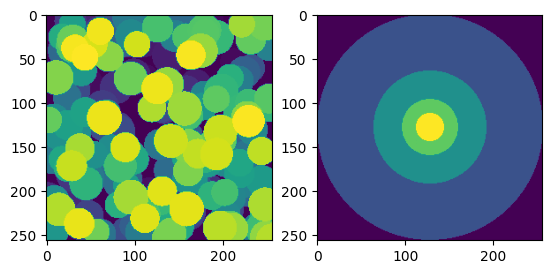

In [11]:
IMG_SHAPE = (256, 256)

shapes = random_shapely_circles(
    image_shape=IMG_SHAPE,
    num_circles=200,
    min_radius=15,
    max_radius=20,
    seed=42,
)

labeled_polygons = [(polygon, idx + 1) for idx, polygon in enumerate(shapes)]
labeled_array = rasterize(
    [(poly, label) for poly, label in labeled_polygons],
    out_shape=IMG_SHAPE,
    fill=0,  # Background value
)

NUM_BROAD_ANNOTATION = 5

broad_annotations = create_broad_annotation_polygons(
    image_shape=IMG_SHAPE,
    annotation_shape="circle",
    num_levels=NUM_BROAD_ANNOTATION,
    downscale_factor=0.5,
)
labeled_broad_annotations = [
    (polygon, idx + 1) for idx, polygon in enumerate(broad_annotations)
]
labeled_broad_annotations = rasterize(
    [(poly, label) for poly, label in labeled_broad_annotations],
    out_shape=IMG_SHAPE,
    fill=0,  # Background value
)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(labeled_array)
ax[1].imshow(labeled_broad_annotations)

shapes = geopandas.GeoDataFrame(geometry=shapes)
broad_df = geopandas.GeoDataFrame(
    {
        "geometry": broad_annotations,
        "broad_annotation_id": np.arange(NUM_BROAD_ANNOTATION),
    }
)
broad_df = broad_df.set_index("broad_annotation_id")
shapes

In [12]:
shapes["spatial_axis"] = spatial_axis(
    shapes, broad_df, np.arange(NUM_BROAD_ANNOTATION), k_neighbours=5
)

shapes

,geometry,spatial_axis
0,"POLYGON ((114.542 243.383, 114.452 241.554, 11...",-0.303225
1,"POLYGON ((169.037 39.941, 168.961 38.394, 168....",-0.265985
2,"POLYGON ((32.875 221.741, 32.788 219.976, 32.5...",-1.255950
3,"POLYGON ((201.116 5.27, 201.021 3.324, 200.735...",-0.714194
4,"POLYGON ((229.014 54.359, 228.938 52.799, 228....",-0.410827
...,...,...
195,"POLYGON ((77.122 19.421, 77.046 17.888, 76.821...",-0.734976
196,"POLYGON ((48.474 38.887, 48.398 37.349, 48.172...",-1.229448
197,"POLYGON ((180.792 46.561, 180.712 44.922, 180....",-0.272278
198,"POLYGON ((247.916 121.334, 247.827 119.537, 24...",-0.188791


[(-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5)]

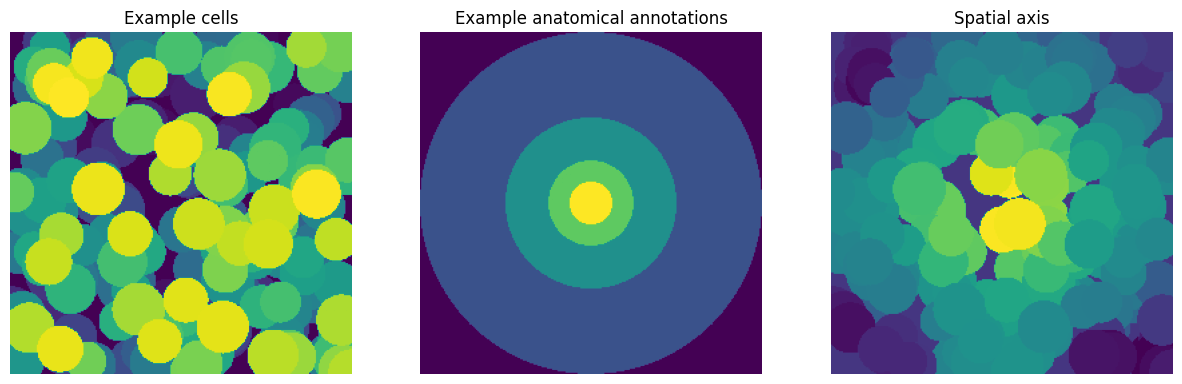

In [13]:
relative_array = spatial_axis_to_labelmap(shapes, IMG_SHAPE, background_value=-1)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(labeled_array)
ax[1].imshow(labeled_broad_annotations)
ax[2].imshow(relative_array)

ax[0].set_title("Example cells")
ax[1].set_title("Example anatomical annotations")
ax[2].set_title("Spatial axis")

[_ax.axis("off") for _ax in ax.flatten()]

# Use a label array to define broad annotations

In [14]:
shapes["spatial_axis"] = spatial_axis(
    shapes, labeled_broad_annotations, np.arange(NUM_BROAD_ANNOTATION), k_neighbours=5
)

shapes

,geometry,spatial_axis
0,"POLYGON ((114.542 243.383, 114.452 241.554, 11...",-0.303225
1,"POLYGON ((169.037 39.941, 168.961 38.394, 168....",-0.265985
2,"POLYGON ((32.875 221.741, 32.788 219.976, 32.5...",-1.255950
3,"POLYGON ((201.116 5.27, 201.021 3.324, 200.735...",-0.714194
4,"POLYGON ((229.014 54.359, 228.938 52.799, 228....",-0.410827
...,...,...
195,"POLYGON ((77.122 19.421, 77.046 17.888, 76.821...",-0.734976
196,"POLYGON ((48.474 38.887, 48.398 37.349, 48.172...",-1.229448
197,"POLYGON ((180.792 46.561, 180.712 44.922, 180....",-0.272278
198,"POLYGON ((247.916 121.334, 247.827 119.537, 24...",-0.188791


[(-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5)]

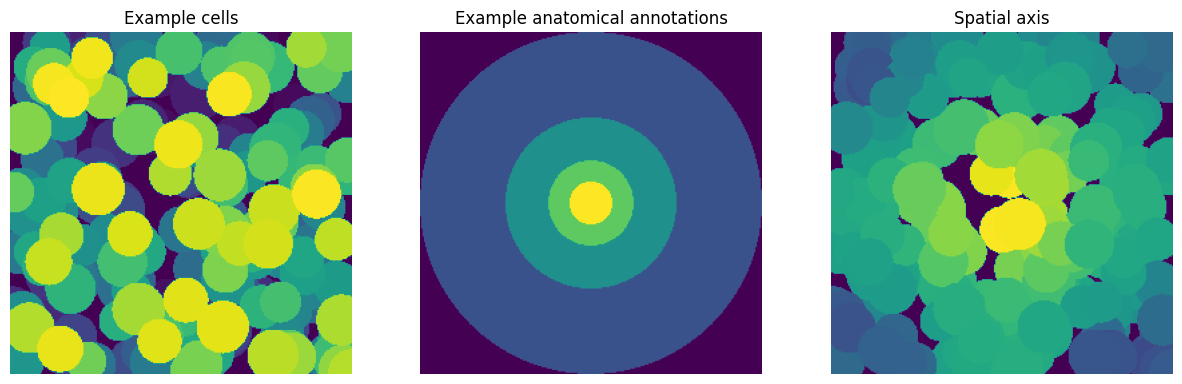

In [15]:
relative_array = spatial_axis_to_labelmap(shapes, IMG_SHAPE, background_value=-2)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(labeled_array)
ax[1].imshow(labeled_broad_annotations)
ax[2].imshow(relative_array)

ax[0].set_title("Example cells")
ax[1].set_title("Example anatomical annotations")
ax[2].set_title("Spatial axis")

[_ax.axis("off") for _ax in ax.flatten()]

# Don't add cells from certain regions to the SpatialAxis

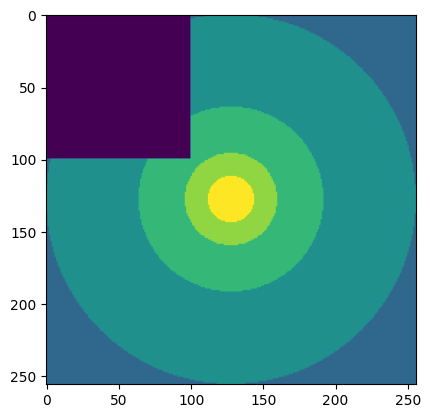

In [16]:
masked_labeled_broad_annotations = labeled_broad_annotations.copy()
# Define a region with a cluster value that is not defined in broad_annotation_order
masked_labeled_broad_annotations[:100, :100] = -1

fig, ax = plt.subplots()
ax.imshow(masked_labeled_broad_annotations)

[(-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5),
 (-0.5, 255.5, 255.5, -0.5)]

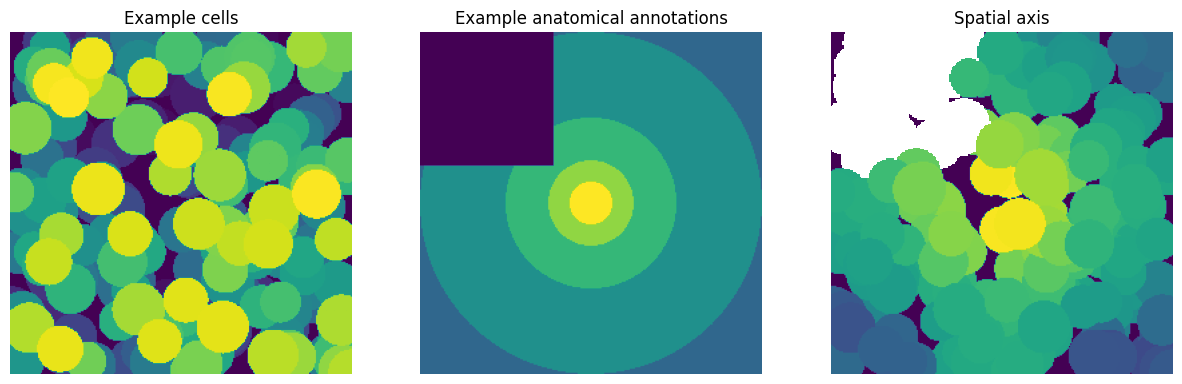

In [17]:
shapes["spatial_axis"] = spatial_axis(
    shapes,
    masked_labeled_broad_annotations,
    broad_annotation_order=np.arange(NUM_BROAD_ANNOTATION),
    broad_annotations_to_exclude=[-1],
    k_neighbours=5,
)

relative_array = spatial_axis_to_labelmap(shapes, IMG_SHAPE, background_value=-2)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(labeled_array)
ax[1].imshow(masked_labeled_broad_annotations)
ax[2].imshow(relative_array)

ax[0].set_title("Example cells")
ax[1].set_title("Example anatomical annotations")
ax[2].set_title("Spatial axis")

[_ax.axis("off") for _ax in ax.flatten()]